# Item Level of the Top 1000 World of Warcraft (WoW) Arena Competitors
A factor of success in WoW's competitive Player vs Player (PvP) game mode is the quality of the players' equipment, quantified by the number: Item Level. The item level of a player is the average of the item levels of each of their 16 equipment slots. The top 1000 players are listed on the official WoW website; their basic details (class, race, server, etc.) can be scraped directly from the ladder page. 

In [ ]:
# Import the stuff
import requests
import scrapy

# Initialize the lists
base_url = 'https://worldofwarcraft.com/en-us/game/pvp/leaderboards/3v3'
names = []
rankings = []
profiles = []
realms = []
ratings = []
classes = []
factions = []
wins = []
losses = []

# Get website as selector object 
for m in range(2):
    if m > 0:
        base_url = base_url.replace('us','gb')
    for n in range(10):
        if n > 0:
            url_modifier = '?page=' + str(n+1)
        else:
            url_modifier = ''
        url = base_url + url_modifier
        html = requests.get(url, headers={
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36"}).content
        sel = scrapy.Selector(text = html)

        # Get the important qualities
        names = names + sel.xpath('//div[@class="Pane-content"]//div[@class="SortTable-row"]//div[@class="SortTable-col SortTable-data"]/@data-value').extract()    
        rankings = rankings + sel.xpath('//div[@class="Pane-content"]//div[@class="SortTable-row"]//div[@class="SortTable-col SortTable-data align-center text-nowrap"]/@data-value').extract()
        profiles_int = sel.xpath('//div[@class="Pane-content"]//div[@class="SortTable-row"]//a[contains(@class, "Link Character")]/@href').extract()
        profiles = profiles + profiles_int
        realms = realms + [item.split('/')[-2] for item in profiles_int]
        ratings = ratings + sel.xpath('//div[@class="Pane-content"]//div[@class="SortTable-row"]//div[@class="List-item"][2]/text()').extract()
        class_urls = sel.xpath('//div[@class="Pane-content"]//div[@class="SortTable-row"]//a[contains(@data-url, "classes")]/@data-url').extract()
        classes = classes + [item.split('/')[-1] for item in class_urls]
        factions_int = sel.xpath('//div[@class="Pane-content"]//div[@class="SortTable-row"]/div[@class="SortTable-col SortTable-data hide font-none align-center"]/@data-value').extract()
        factions = factions + [item.lower() for item in factions_int]
        wins = wins + sel.xpath('//div[@class="Pane-content"]//div[@class="SortTable-row"]//div[contains(@class, "status-success")]/@data-value').extract()
        losses = losses + sel.xpath('//div[@class="Pane-content"]//div[@class="SortTable-row"]//div[contains(@class, "status-error")]/@data-value').extract()
        print('Names: ', len(names))
        print('Ratings: ', len(ratings))
        print('Rankings: ', len(rankings))
        print('Wins: ', len(wins))
        print('Losses: ', len(losses))
        print('Classes: ', len(classes))
        print('Factions: ', len(factions))
        print('Realms: ', len(realms))
        print('Profiles: ', len(profiles))


## Follow the character urls to obtain the Item Level
The item level is not listed directly on the ladder page. However, it is listed on their personal page. So, the urls for the personal pages can be obtained from the ladder page and then followed, where the item level can be scraped.

In [ ]:
# Follow profile link to get ilvl
ilvls = []
print('Starting...')
for profile in profiles:
    if len(ilvls) % 100 == 0:
        print('Player number: ', len(ilvls))
    profile_url = 'https://worldofwarcraft.com' + profile    

    html = requests.get(profile_url, headers={"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2866.71 Safari/537.36"}).content
    sel = scrapy.Selector(text = html)

    weird_dict = sel.xpath('//div[@class="react-mount"]/@data-initial-state').extract()
    if len(weird_dict) > 0:
        ilvls.append(weird_dict[0].split(',')[2].split(':')[-1])
    else:
        ilvls.append(None)
    

## Compile the scraped data into a data frame

In [19]:
# Put into dataframe
ilvls = ilvls + [None]*(1000 - len(ilvls))
import pandas as pd
df = pd.DataFrame({'Rank':rankings, 'Rating':ratings, 'Player':names, 'Wins':wins, 'Losses':losses, 'Item Level':ilvls, 'Class':classes, 'Faction':factions, 'Realm':realms, 'Profile Link':profiles})
unique_classes = df['Class'].unique().tolist()
unique_classes_upper = ['"' + clas.upper() + '"' for clas in unique_classes]
df = df[~df['Item Level'].isin(unique_classes_upper)] # remove garbage found by hand
df = df.astype({'Rating':'float64','Item Level':'float64'}) # convert to float
df = df[df['Item Level'] > 150] # remove outliers
print(df.shape) # check shape

# Get timestamp
from datetime import date
today = str(date.today()).replace('-','_')

# Save dataframe
savename = today + '_wowStats.csv'
df.to_csv(savename)

(1992, 10)


## Display the scatter plot of rating vs item level, colored by class
The most striking feature of the plot is that the highest rated players aren't necessarily those with the highest item level. The black dashed line represents the theoretical maximum item value obtainable by exclusively PvP. To obtain an item level higher than the, a player must participate in Player vs Environment (PvE) content. Judging by the figure, nearly half of the players in the top 1000 of the ladder are competing with gear exceeding the hypothetical maximum of the content they are participating in.

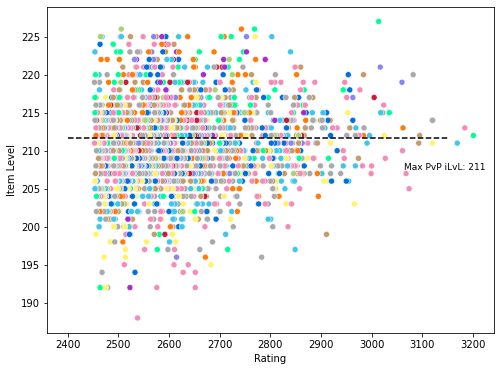

214.0


In [20]:
# Plot it up baybee
import seaborn as sns
import matplotlib.pyplot as plt

class_colors = {"mage": "#3FC7EB", 
                "warlock": "#8788EE",
                "shaman": "#0070DD", 
                "warrior": "#C69B6D", 
                "paladin": "#F48CBA",
                "priest":"#A9A9A9",
                "monk":"#00FF98",
                "demon-hunter":"#A330C9",
                "death-knight":"#C41E3A",
                "druid":"#FF7C0A",  
                "hunter":"#AAD372",
                "rogue":"#FFF468"}

fig, ax = plt.subplots(figsize=(8, 6))
g = sns.scatterplot(data=df[df['Item Level']>180], x='Rating', y='Item Level', hue='Class', palette=class_colors, ax=ax)
mnci = 7 # Max Number Conquest Items besides weapon
pvp_ilvl = [(2*233 + 235 + 226*mnci + 184*(13 - mnci))/16, (2*226 + 235 + 226*mnci + 184*(13 - mnci))/16, \
            (2*220 + 235 + 220*mnci + 184*(13 - mnci))/16, (2*213 + 235 + 213*mnci + 184*(13 - mnci))/16]
ax.plot([2400, 3150], [pvp_ilvl[0], pvp_ilvl[0]], 'k--')
ax.text(0.8, 0.5, 'Max PvP iLvL: '+str(int(pvp_ilvl[0])), fontsize=9, transform=ax.transAxes)
ax.legend().remove()
plt.savefig('rating_vs_ilvl_'+today+'.pdf')
plt.show()
print(df['Item Level'].quantile(0.70))

## Separate the distributions by class
The following 3 figure arrays yield information separated by class. From them we can learn differences, if any, between classes in representation in the top 1000, distribution of item level, and distribution of rating. Some classes (warlock, hunter, death knight, and demon hunter) have very little representation, which could imply the weakness of the class. Interestingly, these classes' item level distributions are skewed toward high-item level, possibly implying that these classes need top-quality equipment in order to be competitive.

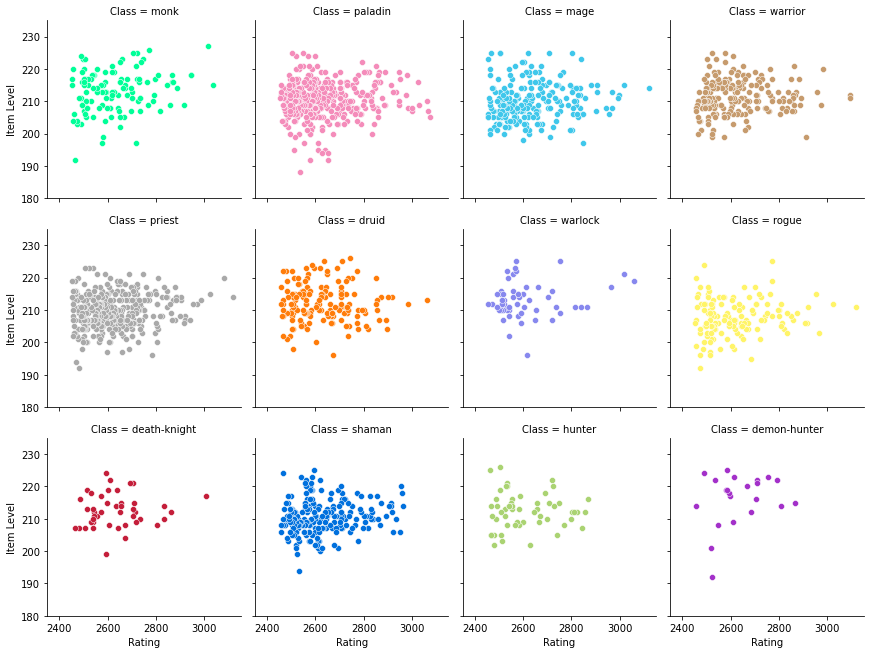

In [21]:
g = sns.FacetGrid(df, col="Class", col_wrap=4, hue="Class", palette=class_colors, ylim=(180,235), xlim=(2350, 3150))
g.map_dataframe(sns.scatterplot, x="Rating", y='Item Level')
g.set_axis_labels("Rating", "Item Level")

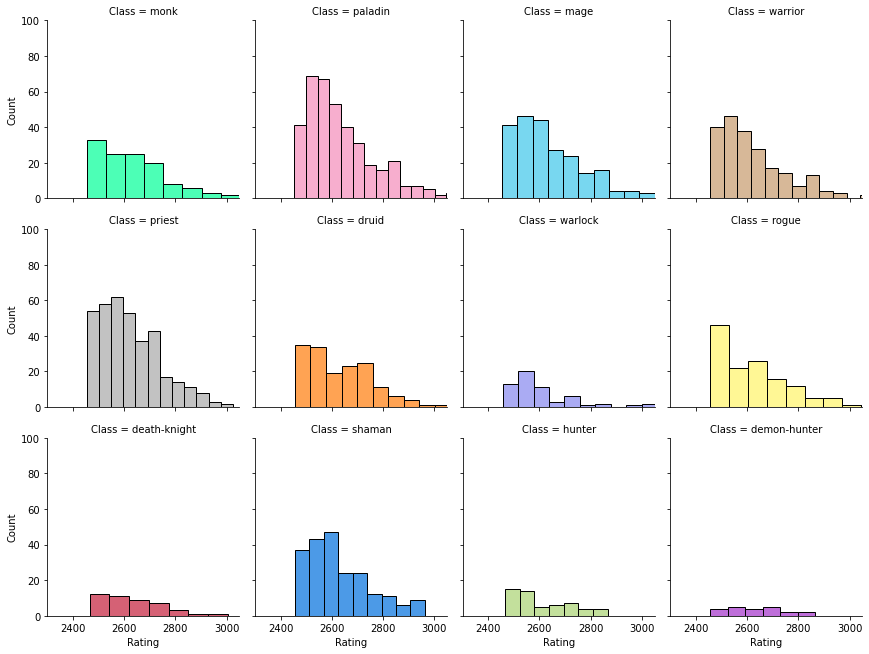

In [22]:
g = sns.FacetGrid(df, col="Class", col_wrap=4, hue="Class", palette=class_colors, ylim=(0,100), xlim=(2300, 3050))
g.map_dataframe(sns.histplot, x="Rating", alpha=.7)
g.set_axis_labels("Rating", "Count")

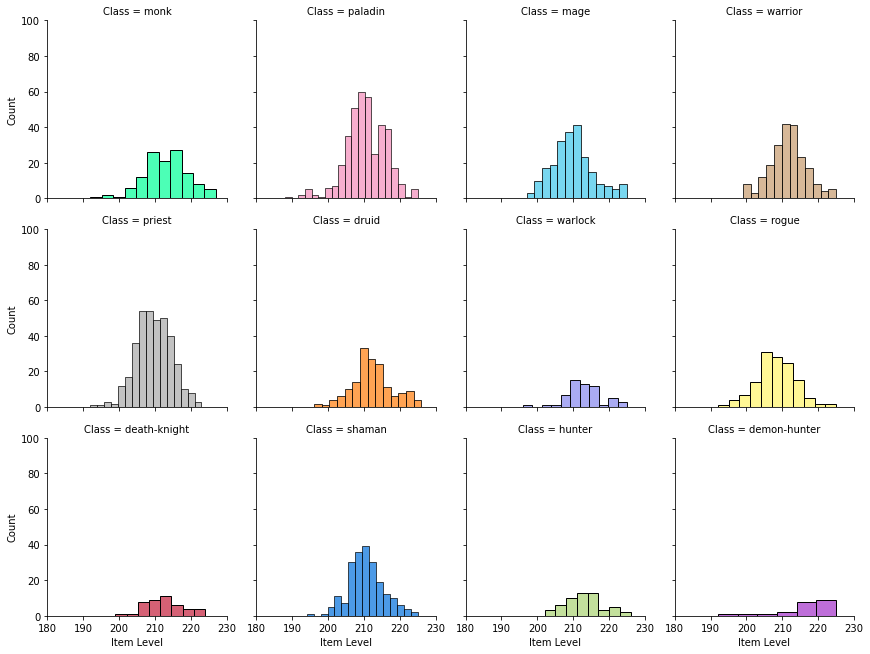

In [23]:
g = sns.FacetGrid(df, col="Class", col_wrap=4, hue="Class", palette=class_colors, ylim=(0,100), xlim=(180, 230))
g.map_dataframe(sns.histplot, x="Item Level", alpha=.7)
g.set_axis_labels("Item Level", "Count")